In [71]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

#Pickling
from six.moves import cPickle as pickle

%matplotlib inline

In [72]:
from keras.layers import Activation, Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer

from gensim.models import word2vec
from gensim.models import KeyedVectors
from glove import Corpus, Glove

In [73]:
def generate_word2vec_text8(saveTo = 'models/text8.model'):
    sentences = word2vec.Text8Corpus('data/text8')
    model = word2vec.Word2Vec(sentences, size=EMBEDDING_DIM)
    model.save(saveTo)
    model.wv.save_word2vec_format(saveTo + '.bin', binary=True)
    print('DONE! Saved to', saveTo)

def generate_glove_text8(saveTo = 'models/glovetext8.model'):
    import itertools
    sentences = list(itertools.islice(word2vec.Text8Corpus('data/text8'),None))
    corpus = Corpus()
    corpus.fit(sentences, window=10)
    glove = Glove(no_components=EMBEDDING_DIM,learning_rate=0.05)
    glove.fit(corpus.matrix, epochs=30,no_threads=4,verbose=True)
    glove.add_dictionary(corpus.dictionary)
    glove.save(saveTo)
    print('DONE! Saved to', saveTo)
    
def load_data(word_count, emotional_mapping):
    # full = generate_IEMOCAP_df()
    data = pd.read_csv('data/IEMOCAP_sentences.csv',index_col=0)
    data['emotion_code'] = data['emotion'].map( emotional_mapping ).astype(int)
    # Take away fear, surprise,disgust, xxx and others. Not enough data
    data = data[data.emotion_code < 4]
    # Clean Transcripts
    data['text'] = data['text'].apply(clean_text)
    # Filter Word Count
    data = filter_word_count(data, word_count)
#     data,patterns = remove_empty_patterns(data,patterns)
    return data

def clean_text(text):
    punct_str = '!"#$%&()*+,-./:;<=>?@\\^_`{|}~«»“…‘”\t'
    for p in punct_str:
        text = text.replace(p,' ')
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[0-9]+", "", text)
    text = re.sub(".*?\[(.*?)\]","",text) # Take out any [action] text in the transcript
    return text.lower().strip()

def filter_word_count(data, n_count):
    return data[list(map(lambda x: len(x.split(' ')) >= n_count,data['text']))]

def balance_data(data):
    min_sample = min(data.groupby('emotion').count()['emotion_code'])
    emotions_list = list(data['emotion'].unique())
    samples = []
    for emotion in emotions_list:
        samples.append(data[data.emotion == emotion].sample(n=min_sample))
    result = pd.concat(samples).sample(frac=1)
    return result


In [74]:
emotional_mapping = {'ang': 0, 'sad': 1, 'hap': 2, 'neu': 3,'fru': 4,'exc': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
data = load_data(5, emotional_mapping)
# data = balance_data(data)
df = data[['text','emotion_code']]
df.groupby('emotion_code').count()

,text
emotion_code,
0,878
1,782
2,412
3,1209


In [75]:
total = sum(data.groupby('emotion').count()['emotion_code'])
((data.groupby('emotion').count() / total) * 100)['emotion_code']

emotion
ang    26.760134
hap    12.557147
neu    36.848522
sad    23.834197
Name: emotion_code, dtype: float64

In [58]:
data_balanced = balance_data(data)
df_balanced = data_balanced[['text','emotion_code']]
df_balanced.head()
data_balanced.groupby('emotion').count()

,start_time,end_time,text,wav_path,valence,arousal,dominance,emotion_code
emotion,,,,,,,,
ang,412,412,412,412,412,412,412,412
hap,412,412,412,412,412,412,412,412
neu,412,412,412,412,412,412,412,412
sad,412,412,412,412,412,412,412,412


## Parameter

In [59]:
# DATASET
TEST_SIZE      = 0.2

# EMBEDDING
MAX_NUM_WORDS  = 2500 #2954, 2500, 2000, 2700
# MAX_NUM_WORDS  = # 1800, 2000, 2201
EMBEDDING_DIM  = 200
MAX_SEQ_LENGTH = 100
USE_GLOVE      = True

# MODEL
FILTER_SIZES   = [3,4,5]
FEATURE_MAPS   = [10,10,10]
DROPOUT_RATE   = 0.5

# LEARNING
BATCH_SIZE     = 200
NB_EPOCHS      = 40
RUNS           = 5
VAL_SIZE       = 0.1

## Preprocessing

In [60]:
x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)

In [61]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

length = max_length(x_train)
word_index = tokenizer.word_index

result = [len(x.split()) for x in x_train]
print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))

print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

Text informations:
max length: 91 / min length: 5 / mean length: 14 / limit length: 100
vocabulary size: 2221 / limit: 2500


In [62]:
len(data), len(y_train)

(2624, 2624)

# Embeddings

In [63]:
def create_glove_embeddings(data = None, use_text8 = False, LEARNING_RATE=0.05, EPOCHS=30, NO_THREADS=4):
    model = None
    if(use_text8):
        model = Glove.load('models/glovetext8.model')
    else:
        if(data != None):
            corpus = Corpus()
            corpus.fit(data, window=10)
            model = Glove(no_components=EMBEDDING_DIM,learning_rate=LEARNING_RATE)
            model.fit(corpus.matrix, epochs=EPOCHS,no_threads=NO_THREADS,verbose=True)
            model.add_dictionary(corpus.dictionary)
        else:
            print('No data found. Using text8 Corpus')
            model = Glove.load('models/glovetext8.model')
    
    embeddings_index = {}
    for word,index in model.dictionary.items():
        embeddings_index[word] = model.word_vectors[index]
    
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM,
                     weights=[embedding_matrix], trainable=True)
    
def create_word2vec_embeddings(data = None, use_text8 = False):
    model = None
    if(use_text8):
        model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    else:
        if(data != None):  
            model = word2vec.Word2Vec(data, size=EMBEDDING_DIM)
        else:
            print('No data found. Using text8 Corpus')
            model = KeyedVectors.load_word2vec_format('models/text8.model.bin',binary=True)
    
    embeddings_index = {}
    for word in model.wv.index2word:
        embeddings_index[word] = model[word]
        
    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
    
    for word, i in tokenizer.word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if(embedding_vector is not None):
            embedding_matrix[i] = embedding_vector
    return Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length = MAX_SEQ_LENGTH,
                    weights= [embedding_matrix], trainable=True)

# Model Definition

## Training

In [64]:
embedding_data = [x.split() for x in x_train]
emb_layers = [create_word2vec_embeddings(use_text8=True),
              create_word2vec_embeddings(embedding_data),
              create_glove_embeddings(use_text8=True),
              create_glove_embeddings(embedding_data)
             ]

emb_layers_names = ['word2vectext8','word2veciemocap','glovetext8','gloveiemocap']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [65]:
print(len(data),len(y_train))

(2624, 2624)


In [ ]:
import cnn_model

histories = []

import time

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    start_time = time.time()
    X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

    emb_layer = None
    if USE_GLOVE:
        emb_layer = emb_layers[2] #create_word2vec_embeddings(result)

    model = cnn_model.build_cnn(
        embedding_layer=emb_layer,
        num_words=MAX_NUM_WORDS,
        embedding_dim=EMBEDDING_DIM,
        filter_sizes=FILTER_SIZES,
        feature_maps=FEATURE_MAPS,
        max_seq_length=MAX_SEQ_LENGTH,
        dropout_rate=DROPOUT_RATE
    )

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adadelta(clipvalue=3),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, labels,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_data=(X_val, y_val),
        callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
                                   verbose=1, save_best_only=True, mode='min'),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
                  ]
    )
    histories.append(history.history)
    print('Iteration', i+1)
    print("--- %s seconds on ---" % (time.time() - start_time))
    
with open('history/unbalanced_'+emb_layers_names[2]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
    pickle.dump(histories, f)

Running iteration 1/5
Creating CNN 0.0.1
#############################################
Embedding:    using pre-trained embedding
Vocabulary size: 2500
Embedding dim: 200
Filter sizes: [3, 4, 5]
Feature maps: [10, 10, 10]
Max sequence: 100
#############################################
Train on 2361 samples, validate on 263 samples
Epoch 1/40
2361/2361 [==============================] - 3s 1ms/step - loss: -5.2221 - acc: 0.2351 - val_loss: -7.0799 - val_acc: 0.2357

Epoch 00001: val_loss improved from inf to -7.07988, saving model to model-1.h5
Epoch 2/40
2361/2361 [==============================] - 2s 948us/step - loss: -8.1353 - acc: 0.2317 - val_loss: -7.2557 - val_acc: 0.2357

Epoch 00002: val_loss improved from -7.07988 to -7.25573, saving model to model-1.h5
Epoch 3/40
2361/2361 [==============================] - 2s 946us/step - loss: -8.3011 - acc: 0.2317 - val_loss: -7.4105 - val_acc: 0.2357

Epoch 00003: val_loss improved from -7.25573 to -7.41053, saving model to model-1.h5
Epo

2361/2361 [==============================] - 2s 935us/step - loss: -9.6235 - acc: 0.2317 - val_loss: -8.6500 - val_acc: 0.2357

Epoch 00036: val_loss improved from -8.64773 to -8.65001, saving model to model-1.h5
Epoch 37/40
2361/2361 [==============================] - 2s 947us/step - loss: -9.6258 - acc: 0.2317 - val_loss: -8.6522 - val_acc: 0.2357

Epoch 00037: val_loss improved from -8.65001 to -8.65215, saving model to model-1.h5
Epoch 38/40
2361/2361 [==============================] - 2s 945us/step - loss: -9.6267 - acc: 0.2317 - val_loss: -8.6510 - val_acc: 0.2357

Epoch 00038: val_loss did not improve from -8.65215
Epoch 39/40
2361/2361 [==============================] - 2s 935us/step - loss: -9.6270 - acc: 0.2317 - val_loss: -8.6547 - val_acc: 0.2357

Epoch 00039: val_loss improved from -8.65215 to -8.65465, saving model to model-1.h5
Epoch 40/40
2361/2361 [==============================] - 2s 947us/step - loss: -9.6236 - acc: 0.2317 - val_loss: -8.6510 - val_acc: 0.2357

Epoch

2361/2361 [==============================] - 2s 938us/step - loss: -9.6273 - acc: 0.2317 - val_loss: -8.6515 - val_acc: 0.2357

Epoch 00031: val_loss improved from -8.65066 to -8.65150, saving model to model-2.h5
Epoch 32/40
2361/2361 [==============================] - 2s 941us/step - loss: -9.6263 - acc: 0.2317 - val_loss: -8.6500 - val_acc: 0.2357

Epoch 00032: val_loss did not improve from -8.65150
Epoch 33/40
2361/2361 [==============================] - 2s 942us/step - loss: -9.6261 - acc: 0.2317 - val_loss: -8.6539 - val_acc: 0.2357

Epoch 00033: val_loss improved from -8.65150 to -8.65394, saving model to model-2.h5
Epoch 34/40
2361/2361 [==============================] - 2s 939us/step - loss: -9.6305 - acc: 0.2317 - val_loss: -8.6541 - val_acc: 0.2357

Epoch 00034: val_loss improved from -8.65394 to -8.65414, saving model to model-2.h5
Epoch 35/40
2361/2361 [==============================] - 2s 942us/step - loss: -9.6305 - acc: 0.2317 - val_loss: -8.6582 - val_acc: 0.2357

Epoch


Epoch 00026: val_loss improved from -8.64842 to -8.64908, saving model to model-3.h5
Epoch 27/40
2361/2361 [==============================] - 2s 946us/step - loss: -9.6270 - acc: 0.2317 - val_loss: -8.6548 - val_acc: 0.2357

Epoch 00027: val_loss improved from -8.64908 to -8.65479, saving model to model-3.h5
Epoch 28/40
2361/2361 [==============================] - 2s 935us/step - loss: -9.6129 - acc: 0.2317 - val_loss: -8.6501 - val_acc: 0.2357

Epoch 00028: val_loss did not improve from -8.65479
Epoch 29/40
2361/2361 [==============================] - 2s 949us/step - loss: -9.6246 - acc: 0.2317 - val_loss: -8.6509 - val_acc: 0.2357

Epoch 00029: val_loss did not improve from -8.65479
Epoch 30/40
2361/2361 [==============================] - 2s 945us/step - loss: -9.6262 - acc: 0.2317 - val_loss: -8.6519 - val_acc: 0.2357

Epoch 00030: val_loss did not improve from -8.65479
Epoch 31/40
2361/2361 [==============================] - 2s 938us/step - loss: -9.6267 - acc: 0.2317 - val_loss: 

In [ ]:
train_predictions = model.predict(X_train, verbose=1)
plt.hist(train_predictions)

In [1]:
# BALANCED DATA
# MAX_NUM_WORDS_AR = [2000, 2201,1800]
# for num in MAX_NUM_WORDS_AR:
#     MAX_NUM_WORDS = num
#     emotional_mapping = {'ang': 0, 'sad': 1, 'exc': 2, 'neu': 3,'fru': 4,'hap': 5,'fea': 6,'sur': 7,'dis': 8, 'xxx':9,'oth':10}
#     data = load_data(3, emotional_mapping)
#     data = balance_data(data)
#     df = data[['text','emotion_code']]
#     df.head()
#     x_train, x_test, y_train, y_test = train_test_split(data.text, data.emotion_code, test_size=TEST_SIZE)
#     tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
#     tokenizer.fit_on_texts(x_train)
#     sequences = tokenizer.texts_to_sequences(x_train)

#     length = max_length(x_train)
#     word_index = tokenizer.word_index

#     result = [len(x.split()) for x in x_train]
#     print('Text informations:')
#     print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
#                                                                                     np.min(result),
#                                                                                     np.mean(result),
#                                                                                     MAX_SEQ_LENGTH))

#     print('vocabulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

#     # Padding all sequences to same length of `MAX_SEQ_LENGTH`
#     data   = pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

#     embedding_data = [x.split() for x in x_train]
#     emb_layers = [create_word2vec_embeddings(use_text8=True),
#                   create_word2vec_embeddings(embedding_data),
#                   create_glove_embeddings(use_text8=True),
#                   create_glove_embeddings(embedding_data)
#                  ]
    
#     ######################################################
#     for index,lay in enumerate(emb_layers):
    
#         histories = []

#         for i in range(RUNS):
#             print('Running iteration %i/%i' % (i+1, RUNS))

#             X_train, X_val, labels, y_val = train_test_split(data, y_train, test_size=VAL_SIZE, random_state=42)

#             emb_layer = None
#             if USE_GLOVE:
#                 emb_layer = lay#emb_layers[2] #create_word2vec_embeddings(result)

#             model = cnn_model.build_cnn(
#                 embedding_layer=emb_layer,
#                 num_words=MAX_NUM_WORDS,
#                 embedding_dim=EMBEDDING_DIM,
#                 filter_sizes=FILTER_SIZES,
#                 feature_maps=FEATURE_MAPS,
#                 max_seq_length=MAX_SEQ_LENGTH,
#                 dropout_rate=DROPOUT_RATE
#             )

#             model.compile(
#                 loss='binary_crossentropy',
#                 optimizer=Adadelta(clipvalue=3),
#                 metrics=['accuracy']
#             )

#             history = model.fit(
#                 X_train, labels,
#                 epochs=NB_EPOCHS,
#                 batch_size=BATCH_SIZE,
#                 verbose=1,
#                 validation_data=(X_val, y_val),
#                 callbacks=[ModelCheckpoint('model-%i.h5'%(i+1), monitor='val_loss',
#                                            verbose=1, save_best_only=True, mode='min'),
#                            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.01)
#                           ]
#             )
#             histories.append(history.history)

#         with open('history/balanced_'+emb_layers_names[index]+'_'+str(MAX_NUM_WORDS)+'.pkl', 'wb') as f:
#             pickle.dump(histories, f)
    



In [ ]:
plt.hist(train_predictions)
plt.hist(test_predictions)

In [101]:
with open('history/unbalanced_glovetext8_2954.pkl', 'wb') as f:
    pickle.dump(histories, f)

# Evaluation 

In [273]:
histories = pickle.load(open('history/unbalanced_glovetext8_2500.pkl', 'rb'))

In [ ]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

In [260]:

def  plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

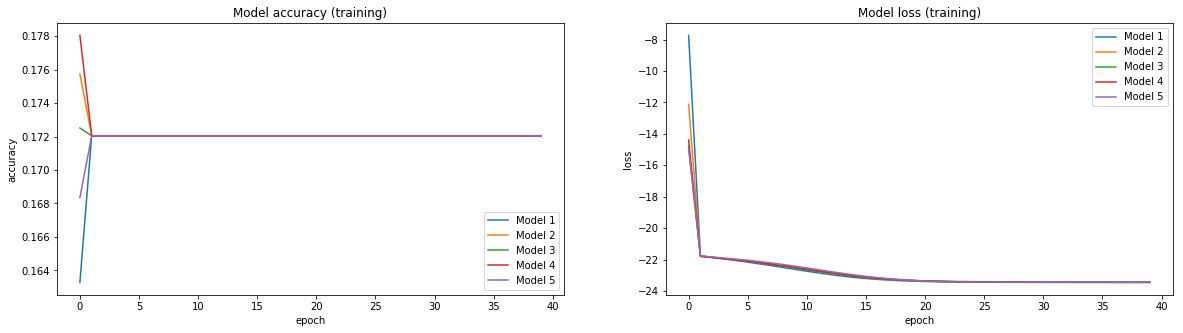

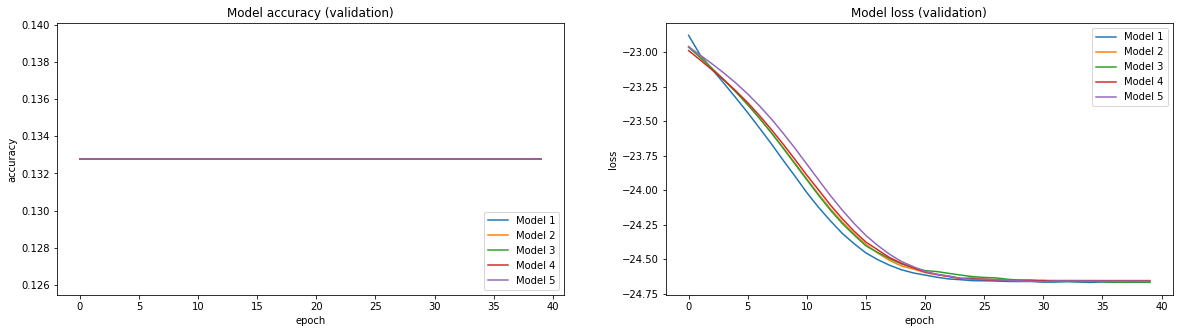

In [261]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')